In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mass_ts as mts

%matplotlib inline

In [2]:
import tarfile

def load_file(archive, fp):
    """
    Utility function that reads a tar file directly into a numpy array.
    
    Parameters
    ----------
    archive : str
        The archive file to read.
    fp : str
        The file path of the file to read relative to the archive.
    
    
    Returns
    -------
    None if data reading failed or the numpy array of values.
    """
    data = None
    with tarfile.open(archive) as a:
        f = a.extractfile(dict(zip(a.getnames(),a.getmembers()))[fp])
        data = pd.read_csv(f, header=None, names=['reading', ])['reading'].values
    
    return data

In [3]:
%%time
ecg = load_file('ecg.tar.gz', 'ecg.txt')
ecg_query = load_file('ecg_query.tar.gz', 'ecg_query.txt')

CPU times: user 4.72 s, sys: 372 ms, total: 5.09 s
Wall time: 5.09 s


In [4]:
print('ECG data length is {:,}'.format(len(ecg)))
print('Query length is {:,}'.format(len(ecg_query)))

ECG data length is 20,140,000
Query length is 421


In [5]:
# total number of matches we want returned
top_matches = 5

# length of the subsequence to search in batch processing.
# note that this has an impact on memory usage
batch_size = 10000

In [6]:
%%time
best_indices, best_dists = mts.mass2_batch(ecg, ecg_query, batch_size=batch_size, top_matches=top_matches)

CPU times: user 54.3 s, sys: 232 ms, total: 54.5 s
Wall time: 54.5 s


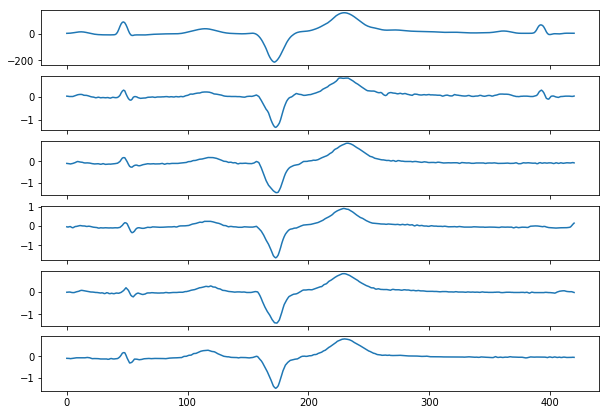

In [7]:
# Plot the query with top matches
fig, axes = plt.subplots(top_matches + 1,1,sharex=True,figsize=(10,7))
axes[0].plot(np.arange(len(ecg_query)), ecg_query)

for ax, idx in zip(axes[1:], best_indices):
    ax.plot(np.arange(len(ecg_query)), ecg[idx:idx+len(ecg_query)])
    #ax.set_ylabel('Index {}'.format(idx), size=12)

plt.show()

In [8]:
# run same task with 4 cpu threads
n_jobs = 4

In [9]:
%%time
best_indices, best_dists = mts.mass2_batch(ecg, ecg_query, batch_size=batch_size, top_matches=top_matches, n_jobs=n_jobs)

CPU times: user 1.11 s, sys: 436 ms, total: 1.54 s
Wall time: 23.3 s


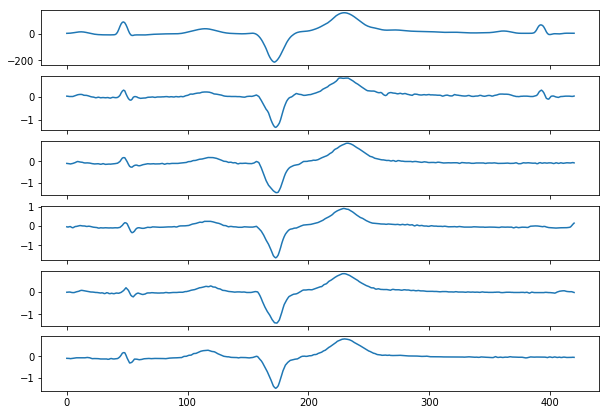

In [10]:
# Plot the query with top matches
fig, axes = plt.subplots(top_matches + 1,1,sharex=True,figsize=(10,7))
axes[0].plot(np.arange(len(ecg_query)), ecg_query)

for ax, idx in zip(axes[1:], best_indices):
    ax.plot(np.arange(len(ecg_query)), ecg[idx:idx+len(ecg_query)])
    #ax.set_ylabel('Index {}'.format(idx), size=12)

plt.show()